In [1]:
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.circuit.library import QFT as qkQFT
from qiskit.visualization import plot_histogram
from quantumrings.toolkit.qiskit import QrBackendV2, QrSamplerV1
from QuantumRingsLib import QuantumRingsProvider

import numpy as np

# Provider & backend (toolkit)
provider = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits=2)

# Helper Functions

Functions to convert a decimal to binary fractions (ex. 1/10 --> 0.00011), and convert a binary number to an integer (ex. 10 --> 2).

In [3]:
def decimal_to_binary_fraction(x, bits=20):

    binary = "0."
    for _ in range(bits):
        x *= 2
        if x >= 1:
            binary += "1"
            x -= 1
        else:
            binary += "0"

    return binary

def binary_to_int(binary):
    return int(binary, 2)

In [4]:
def prep_state(num_qubits, period):

    qr = QuantumRegister(num_qubits+1)
    qc = QuantumCircuit(qr)
    
    qc.x(num_qubits)
    
    qc.h(range(0,num_qubits))

    for j in range(num_qubits-1, -1,-1):
        qc.cp(2*np.pi * 2**j / period ,j,num_qubits)
    
    qc.x(num_qubits)

    return qc

┌───┐                                                            
q15_0: ┤ H ├──────────────────────────────────────────────■─────────────
       ├───┤                                              │             
q15_1: ┤ H ├───────────────────────────────────■──────────┼─────────────
       ├───┤                                   │          │             
q15_2: ┤ H ├────────────────────────■──────────┼──────────┼─────────────
       ├───┤                        │          │          │             
q15_3: ┤ H ├─────────────■──────────┼──────────┼──────────┼─────────────
       ├───┤             │          │          │          │             
q15_4: ┤ H ├─■───────────┼──────────┼──────────┼──────────┼─────────────
       ├───┤ │P(-16π/5)  │P(-8π/5)  │P(-4π/5)  │P(-2π/5)  │P(-π/5) ┌───┐
q15_5: ┤ X ├─■───────────■──────────■──────────■──────────■────────┤ X ├
       └───┘                                                       └───┘
 c7: 5/═════════════════════════════════════════════════════════════════

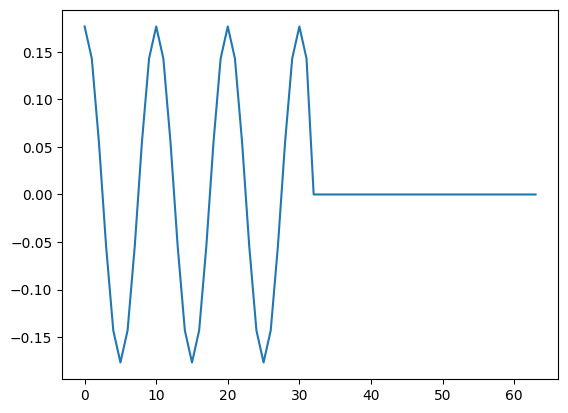

In [16]:
num_qubits = 5
qr = QuantumRegister(num_qubits+1)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)

qc.compose(prep_state(num_qubits,10),inplace=True)
display(qc.draw())

sv = Statevector.from_instruction(qc)
plt.plot(np.real(sv))

In [5]:
def QFT(num_qubits):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr,cr)
    
    # for i in range(num_qubits-1,-1,-1):
    #     qc.h(i)

    for i in range(0, num_qubits):
        qc.h(i)

        for j in range(i+1,num_qubits,1):
            denominator = 2**(j-i)
            qc.cp(np.pi/denominator, j,i)
    
        # for j in range(i-1,-1,-1):
        #     denominator = 2**(i-j)
        #     qc.cp(np.pi/denominator, j,i)
        qc.barrier()

    # qc.swap(0,2)

    return qc

In [7]:
num_qubits = 4
qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)

iQFT = QFT(num_qubits).inverse()
qc.compose(iQFT,inplace=True)
# qc.compose(QFT(num_qubits),inplace=True)
# qc.barrier()
# qc.append(qkQFT(num_qubits, inverse=True),range(num_qubits))

qc.barrier()

qc.measure(qr,cr)
backend = QrBackendV2(provider, num_qubits=num_qubits+1)
qc_tp = transpile(qc, backend)

qc_tp.draw()
# qc.draw()

░ ┌───┐ ░                 ░                           ░ »
     q2_0 -> 0 ─░─┤ H ├─░──■──────────────░──■────────────────────────░─»
                ░ └───┘ ░  │P(-π/2) ┌───┐ ░  │                        ░ »
     q2_1 -> 1 ─░───────░──■────────┤ H ├─░──┼─────────■──────────────░─»
                ░       ░           └───┘ ░  │P(-π/4)  │P(-π/2) ┌───┐ ░ »
     q2_2 -> 2 ─░───────░─────────────────░──■─────────■────────┤ H ├─░─»
                ░       ░                 ░                     └───┘ ░ »
     q2_3 -> 3 ─░───────░─────────────────░───────────────────────────░─»
                ░       ░                 ░                           ░ »
ancilla_0 -> 4 ─────────────────────────────────────────────────────────»
                                                                        »
         c1: 4/═════════════════════════════════════════════════════════»
                                                                        »
«                                                   ░ ┌─┐         
«     q2_0 -> 0 ─■──────────────────────────────────░─┤M├─────────
«                │                                  ░ └╥┘┌─┐      
«     q2_1 -> 1 ─┼─────────■────────────────────────░──╫─┤M├──────
«                │         │                        ░  ║ └╥┘┌─┐   
«     q2_2 -> 2 ─┼─────────┼─────────■──────────────░──╫──╫─┤M├───
«                │P(-π/8)  │P(-π/4)  │P(-π/2) ┌───┐ ░  ║  ║ └╥┘┌─┐
«     q2_3 -> 3 ─■─────────■─────────■────────┤ H ├─░──╫──╫──╫─┤M├
«                                             └───┘ ░  ║  ║  ║ └╥┘
«ancilla_0 -> 4 ───────────────────────────────────────╫──╫──╫──╫─
«                                                      ║  ║  ║  ║ 
«         c1: 4/═══════════════════════════════════════╩══╩══╩══╩═
«                                                      0  1  2  3

In [8]:
num_qubits = 4
qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)

# iQFT = QFT(num_qubits).inverse()
# qc.compose(iQFT,inplace=True)
# qc.compose(QFT(num_qubits),inplace=True)
# qc.barrier()
qc.append(qkQFT(num_qubits, inverse=True),range(num_qubits))

qc.barrier()

qc.measure(qr,cr)
backend = QrBackendV2(provider, num_qubits=num_qubits+1)
qc_tp = transpile(qc, backend)

qc_tp.draw()
# qc.draw()

┌───┐                                                  »
     q4_3 -> 0 ┤ H ├─■──────────────■───────────────────■─────────────»
               └───┘ │P(-π/2) ┌───┐ │                   │             »
     q4_2 -> 1 ──────■────────┤ H ├─┼─────────■─────────┼─────────────»
                              └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐»
     q4_1 -> 2 ─────────────────────■─────────■─────────┼────────┤ H ├»
                                                        │P(-π/8) └───┘»
     q4_0 -> 3 ─────────────────────────────────────────■─────────────»
                                                                      »
ancilla_0 -> 4 ───────────────────────────────────────────────────────»
                                                                      »
         c2: 4/═══════════════════════════════════════════════════════»
                                                                      »
«                                         ░ ┌─┐         
«     q4_3 -> 0 ──────────────────────────░─┤M├─────────
«                                         ░ └╥┘┌─┐      
«     q4_2 -> 1 ─■────────────────────────░──╫─┤M├──────
«                │                        ░  ║ └╥┘┌─┐   
«     q4_1 -> 2 ─┼─────────■──────────────░──╫──╫─┤M├───
«                │P(-π/4)  │P(-π/2) ┌───┐ ░  ║  ║ └╥┘┌─┐
«     q4_0 -> 3 ─■─────────■────────┤ H ├─░──╫──╫──╫─┤M├
«                                   └───┘ ░  ║  ║  ║ └╥┘
«ancilla_0 -> 4 ─────────────────────────────╫──╫──╫──╫─
«                                            ║  ║  ║  ║ 
«         c2: 4/═════════════════════════════╩══╩══╩══╩═
«                                            0  1  2  3

In [43]:
num_qubits = 5
qr = QuantumRegister(num_qubits+1)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)

qc.compose(prep_state(num_qubits,5),inplace=True)
qc.barrier()

iQFT = QFT(num_qubits).inverse()
qc.compose(iQFT,inplace=True)
# qc.compose(QFT(num_qubits),inplace=True)
# qc.barrier()
# qc.append(qkQFT(num_qubits, inverse=True),range(num_qubits))


qc.barrier()

qc.measure(qr[:-1][::-1],cr)
# qc.draw()
# Transpile for Quantum Rings
backend = QrBackendV2(provider, num_qubits=num_qubits+1)
qc_tp = transpile(qc, backend)

qc_tp.draw()

┌───┐                                                     ┌───┐ ░ »
q13_5 -> 0 ┤ X ├─■───────────■──────────■─────────■─────────■────────┤ X ├─░─»
           ├───┤ │           │          │         │         │P(2π/5) └───┘ ░ »
q13_0 -> 1 ┤ H ├─┼───────────┼──────────┼─────────┼─────────■──────────────░─»
           ├───┤ │           │          │         │P(4π/5)                 ░ »
q13_1 -> 2 ┤ H ├─┼───────────┼──────────┼─────────■────────────────────────░─»
           ├───┤ │           │          │P(8π/5)                           ░ »
q13_2 -> 3 ┤ H ├─┼───────────┼──────────■──────────────────────────────────░─»
           ├───┤ │           │P(16π/5)                                     ░ »
q13_3 -> 4 ┤ H ├─┼───────────■─────────────────────────────────────────────░─»
           ├───┤ │P(20.106)                                                ░ »
q13_4 -> 5 ┤ H ├─■─────────────────────────────────────────────────────────░─»
           └───┘                                                           ░ »
     c5: 5/══════════════════════════════════════════════════════════════════»
                                                                             »
«                                                                              »
«q13_5 -> 0 ───────────────────────────────────────────────────────────────────»
«            ░       ░                 ░                           ░           »
«q13_0 -> 1 ─░───────░─────────────────░───────────────────────────░───────────»
«            ░       ░                 ░                           ░           »
«q13_1 -> 2 ─░───────░─────────────────░───────────────────────────░──■────────»
«            ░       ░                 ░                     ┌───┐ ░  │        »
«q13_2 -> 3 ─░───────░─────────────────░──■─────────■────────┤ H ├─░──┼────────»
«            ░       ░           ┌───┐ ░  │         │P(-π/2) └───┘ ░  │        »
«q13_3 -> 4 ─░───────░──■────────┤ H ├─░──┼─────────■──────────────░──┼────────»
«            ░ ┌───┐ ░  │P(-π/2) └───┘ ░  │P(-π/4)                 ░  │P(-π/8) »
«q13_4 -> 5 ─░─┤ H ├─░──■──────────────░──■────────────────────────░──■────────»
«            ░ └───┘ ░                 ░                           ░           »
«     c5: 5/═══════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                      »
«q13_5 -> 0 ───────────────────────────────────────────────────────────»
«                                     ░                                »
«q13_0 -> 1 ──────────────────────────░──■──────────■─────────■────────»
«                               ┌───┐ ░  │          │         │        »
«q13_1 -> 2 ─■─────────■────────┤ H ├─░──┼──────────┼─────────┼────────»
«            │         │P(-π/2) └───┘ ░  │          │         │P(-π/4) »
«q13_2 -> 3 ─┼─────────■──────────────░──┼──────────┼─────────■────────»
«            │P(-π/4)                 ░  │          │P(-π/8)           »
«q13_3 -> 4 ─■────────────────────────░──┼──────────■──────────────────»
«                                     ░  │P(-π/16)                     »
«q13_4 -> 5 ──────────────────────────░──■─────────────────────────────»
«                                     ░                                »
«     c5: 5/═══════════════════════════════════════════════════════════»
«                                                                      »
«                           ░                
«q13_5 -> 0 ────────────────░────────────────
«                     ┌───┐ ░             ┌─┐
«q13_0 -> 1 ─■────────┤ H ├─░─────────────┤M├
«            │P(-π/2) └───┘ ░          ┌─┐└╥┘
«q13_1 -> 2 ─■──────────────░──────────┤M├─╫─
«                           ░       ┌─┐└╥┘ ║ 
«q13_2 -> 3 ────────────────░───────┤M├─╫──╫─
«                           ░    ┌─┐└╥┘ ║  ║ 
«q13_3 -> 4 ────────────────░────┤M├─╫──╫──╫─
«                           ░ ┌─┐└╥┘ ║  ║  ║ 
«q13_4 -> 

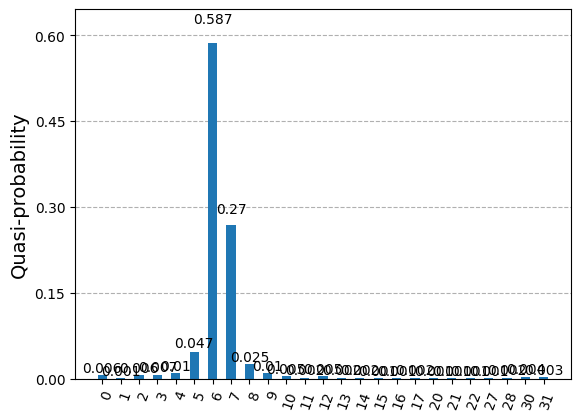

In [44]:
# Execute with toolkit sampler
sampler = QrSamplerV1(backend=backend)
job = sampler.run(circuits=[qc_tp])

counts = job.result().quasi_dists[0]
plot_histogram(counts)

In [46]:
fraction = 1/3

In [47]:
binary_fraction = decimal_to_binary_fraction(fraction, bits=5)

In [48]:
def binary_to_int(binary):
    return int(binary, 2)

In [49]:
binary_fraction[2:]

'01010'

In [50]:
binary_to_int(binary_fraction[2:])

10

# two phases

create an equal superposition of $|\psi_1\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n} e^{-2\pi i x / 5} |x\rangle$ and $|\psi_2\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n} e^{-2\pi i x / 2} |x\rangle$

In [18]:
def prep_state_v2(num_qubits, period1,period2):

    qr = QuantumRegister(num_qubits+1)
    qc = QuantumCircuit(qr)
    
    qc.x(num_qubits)
    
    qc.h(range(0,num_qubits))

    for j in range(num_qubits-1, -1,-1):
        qc.cp(2*np.pi * 2**j / period1 ,j,num_qubits)
    for j in range(num_qubits-1, -1,-1):
        qc.cp(2*np.pi * 2**j / period2 ,j,num_qubits)
    
    qc.x(num_qubits)

    return qc

In [ ]:
num_qubits = 5

In [63]:
qc = QuantumCircuit(num_qubits+1)
qc.compose(prep_state(num_qubits,5),inplace=True)
custom1 = qc.to_gate().control(1)

qc = QuantumCircuit(num_qubits+1)
qc.compose(prep_state(num_qubits,2),inplace=True)
custom2 = qc.to_gate().control(1)

In [64]:

qr = QuantumRegister(num_qubits+2)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)

qc.h(num_qubits+1)

qc.append(custom1, [num_qubits+1]+list(range(num_qubits+1)))

qc.x(num_qubits+1)


qc.append(custom2, [num_qubits+1]+list(range(num_qubits+1)))

# qc.compose(prep_state(num_qubits,3),inplace=True)

qc.barrier()

iQFT = QFT(num_qubits).inverse()
qc.compose(iQFT,inplace=True)
# qc.compose(QFT(num_qubits),inplace=True)
# qc.barrier()
# qc.append(qkQFT(num_qubits, inverse=True),range(num_qubits))


qc.barrier()

qc.measure(qr[:-2][::-1],cr)
# qc.draw()
# Transpile for Quantum Rings
backend = QrBackendV2(provider, num_qubits=num_qubits+2)
qc_tp = transpile(qc, backend)

# qc_tp.draw()

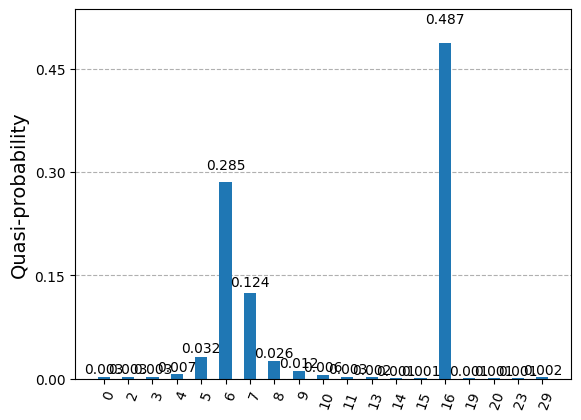

In [65]:
# Execute with toolkit sampler
sampler = QrSamplerV1(backend=backend)
job = sampler.run(circuits=[qc_tp])

counts = job.result().quasi_dists[0]
plot_histogram(counts)

In [59]:
fraction = 1/5
binary_fraction = decimal_to_binary_fraction(fraction, bits=5)
binary_to_int(binary_fraction[2:])

6

In [62]:
fraction = 1/2
binary_fraction = decimal_to_binary_fraction(fraction, bits=5)
binary_to_int(binary_fraction[2:])

16

6

# flip order of everything/

In [32]:
def prep_state(num_qubits, period):

    qr = QuantumRegister(num_qubits+1)
    qc = QuantumCircuit(qr)
    
    qc.x(0)
    
    qc.h(range(1,num_qubits+1))

    for j in range(1,num_qubits):
        qc.cp(-2*np.pi * 2**(num_qubits-j) / period ,j,0)
    
    qc.x(0)

    return qc

┌───┐                                                          ┌───┐
q32_0: ┤ X ├─■────────────■───────────■──────────■──────────■─────────┤ X ├
       ├───┤ │P(-20.106)  │           │          │          │         └───┘
q32_1: ┤ H ├─■────────────┼───────────┼──────────┼──────────┼──────────────
       ├───┤              │P(-16π/5)  │          │          │              
q32_2: ┤ H ├──────────────■───────────┼──────────┼──────────┼──────────────
       ├───┤                          │P(-8π/5)  │          │              
q32_3: ┤ H ├──────────────────────────■──────────┼──────────┼──────────────
       ├───┤                                     │P(-4π/5)  │              
q32_4: ┤ H ├─────────────────────────────────────■──────────┼──────────────
       ├───┤                                                │P(-2π/5)      
q32_5: ┤ H ├────────────────────────────────────────────────■──────────────
       ├───┤                                                               
q32_6: ┤ H ├───────────────────────────────────────────────────────────────
       └───┘                                                               
c12: 6/════════════════════════════════════════════════════════════════════

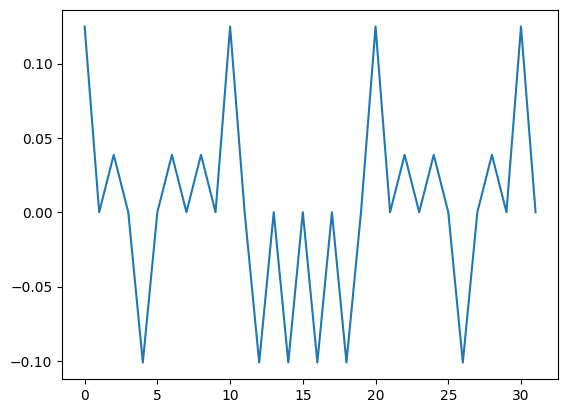

In [33]:
num_qubits = 6
qr = QuantumRegister(num_qubits+1)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)

qc.compose(prep_state(num_qubits,10),inplace=True)
display(qc.draw())

sv = Statevector.from_instruction(qc)
plt.plot(np.real(sv)[:32])

In [36]:
num_qubits = 5
qr = QuantumRegister(num_qubits+1)
cr = ClassicalRegister(num_qubits)
qc = QuantumCircuit(qr,cr)

qc.compose(prep_state(num_qubits,10),inplace=True)
qc.barrier()
iQFT = QFT(num_qubits).inverse()
qc.compose(iQFT,qr[1:],inplace=True)


qc.barrier()

qc.measure(qr[1:],cr)
qc.draw()

┌───┐                                             ┌───┐ ░            »
q40_0: ┤ X ├─■───────────■──────────■──────────■─────────┤ X ├─░────────────»
       ├───┤ │P(-16π/5)  │          │          │         └───┘ ░  ░       ░ »
q40_1: ┤ H ├─■───────────┼──────────┼──────────┼───────────────░──░───────░─»
       ├───┤             │P(-8π/5)  │          │               ░  ░       ░ »
q40_2: ┤ H ├─────────────■──────────┼──────────┼───────────────░──░───────░─»
       ├───┤                        │P(-4π/5)  │               ░  ░       ░ »
q40_3: ┤ H ├────────────────────────■──────────┼───────────────░──░───────░─»
       ├───┤                                   │P(-2π/5)       ░  ░       ░ »
q40_4: ┤ H ├───────────────────────────────────■───────────────░──░───────░─»
       ├───┤                                                   ░  ░ ┌───┐ ░ »
q40_5: ┤ H ├───────────────────────────────────────────────────░──░─┤ H ├─░─»
       └───┘                                                   ░  ░ └───┘ ░ »
c15: 5/═════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                       »
«q40_0: ────────────────────────────────────────────────────────────────»
«                         ░                               ░             »
«q40_1: ──────────────────░───────────────────────────────░─────────────»
«                         ░                               ░ ┌──────────┐»
«q40_2: ──────────────────░───────────────────────────────░─┤ Rz(-π/8) ├»
«                         ░ ┌──────────┐┌──────────┐┌───┐ ░ └────┬─────┘»
«q40_3: ──────────────────░─┤ Rz(-π/4) ├┤ Rz(-π/2) ├┤ H ├─░──────┼──────»
«       ┌──────────┐┌───┐ ░ └────┬─────┘└────┬─────┘└───┘ ░      │      »
«q40_4: ┤ Rz(-π/2) ├┤ H ├─░──────┼───────────■────────────░──────┼──────»
«       └────┬─────┘└───┘ ░      │                        ░      │      »
«q40_5: ─────■────────────░──────■────────────────────────░──────■──────»
«                         ░                               ░             »
«c15: 5/════════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                            »
«q40_0: ─────────────────────────────────────────────────────────────────────»
«                                     ░ ┌───────────┐┌──────────┐┌──────────┐»
«q40_1: ──────────────────────────────░─┤ Rz(-π/16) ├┤ Rz(-π/8) ├┤ Rz(-π/4) ├»
«       ┌──────────┐┌──────────┐┌───┐ ░ └─────┬─────┘└────┬─────┘└────┬─────┘»
«q40_2: ┤ Rz(-π/4) ├┤ Rz(-π/2) ├┤ H ├─░───────┼───────────┼───────────┼──────»
«       └────┬─────┘└────┬─────┘└───┘ ░       │           │           │      »
«q40_3: ─────┼───────────■────────────░───────┼───────────┼───────────■──────»
«            │                        ░       │           │                  »
«q40_4: ─────■────────────────────────░───────┼───────────■──────────────────»
«                                     ░       │                              »
«q40_5: ──────────────────────────────░───────■──────────────────────────────»
«                                     ░                                      »
«c15: 5/═════════════════════════════════════════════════════════════════════»
«                                                                            »
«                         ░                
«q40_0: ──────────────────░────────────────
«       ┌──────────┐┌───┐ ░ ┌─┐            
«q40_1: ┤ Rz(-π/2) ├┤ H ├─░─┤M├────────────
«       └────┬─────┘└───┘ ░ └╥┘┌─┐         
«q40_2: ─────■────────────░──╫─┤M├─────────
«                         ░  ║ └╥┘┌─┐      
«q40_3: ──────────────────░──╫──╫─┤M├──────
«                         ░  ║  ║ └╥┘┌─┐   
«q40_4: ──────────────────░──╫──╫──╫─┤M├───
«                         ░  ║  ║  ║ └╥┘┌─┐
«q40_5: ──────────────────░──╫──╫──╫──╫─┤M├
«             

In [37]:
# Transpile for Quantum Rings
backend = QrBackendV2(provider, num_qubits=num_qubits+1)
qc_tp = transpile(qc, backend)

# qc_tp.draw()

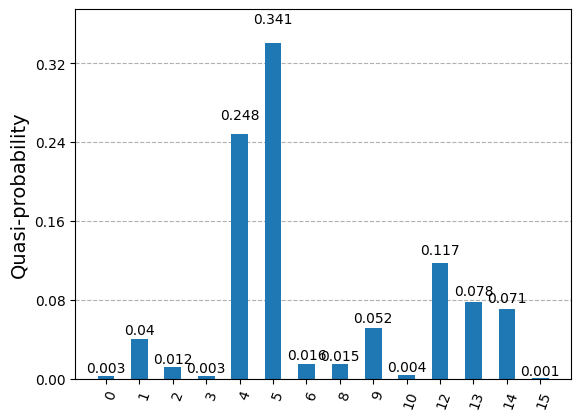

In [38]:
# Execute with toolkit sampler
sampler = QrSamplerV1(backend=backend)
job = sampler.run(circuits=[qc_tp])

counts = job.result().quasi_dists[0]
plot_histogram(counts)